In [2]:
import transformers
wavlm_model = transformers.AutoModel.from_pretrained(
        "microsoft/wavlm-base"
    )

/home/wnakata/lightning-vocoders/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
processor = transformers.AutoFeatureExtractor.from_pretrained("microsoft/wavlm-base")
wavlm_model

WavLMModel(
  (feature_extractor): WavLMFeatureEncoder(
    (conv_layers): ModuleList(
      (0): WavLMGroupNormConvLayer(
        (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
        (activation): GELUActivation()
        (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
      )
      (1-4): 4 x WavLMNoLayerNormConvLayer(
        (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
        (activation): GELUActivation()
      )
      (5-6): 2 x WavLMNoLayerNormConvLayer(
        (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
        (activation): GELUActivation()
      )
    )
  )
  (feature_projection): WavLMFeatureProjection(
    (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (projection): Linear(in_features=512, out_features=768, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): WavLMEncoder(
    (pos_conv_embed): WavLMPositionalConvEmbedding(
      (conv): Conv1d(768, 

In [4]:
wavlm_model.feature_extractor

WavLMFeatureEncoder(
  (conv_layers): ModuleList(
    (0): WavLMGroupNormConvLayer(
      (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
      (activation): GELUActivation()
      (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
    )
    (1-4): 4 x WavLMNoLayerNormConvLayer(
      (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
      (activation): GELUActivation()
    )
    (5-6): 2 x WavLMNoLayerNormConvLayer(
      (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
      (activation): GELUActivation()
    )
  )
)

In [1]:
def calc_wavlm_length(x):
    def calc_conv_length(in_length,kernel,stride):
        return (in_length + (kernel -1 )-1)/stride

    x = calc_conv_length(x,10,5)
    x = calc_conv_length(x,3,2)
    x = calc_conv_length(x,3,2)
    x = calc_conv_length(x,3,2)
    x = calc_conv_length(x,3,2)
    x = calc_conv_length(x,2,2)
    x = calc_conv_length(x,2,2)
    return x

In [5]:
1/(calc_wavlm_length(160000000000000)/160000000000000)

319.99999999983396

In [7]:
import torchaudio
import torch
from pathlib import Path
from tqdm import tqdm
wav_files = list(Path("/mnt/hdd/datasets/jvs_ver1/").glob("**/*.wav"))
outputs = []
filenames = []
wavlm_model.to('cuda')
for wav_file in tqdm(wav_files):
    wav_tensor,sr = torchaudio.load(wav_file)
    wav_tensor = torchaudio.functional.resample(waveform=wav_tensor,orig_freq=sr,new_freq=16_000)
    inputs = processor(wav_tensor.squeeze(),return_tensors='pt',sampling_rate=16_000)
    inputs.to('cuda')
    with torch.no_grad():
        output = wavlm_model(**inputs,output_hidden_states=True)
    outputs.append(torch.stack(output.hidden_states).cpu().mean(axis=2).numpy())
    filenames.append(wav_file)


  0%|          | 0/14997 [00:00<?, ?it/s]/home/wnakata/lightning-vocoders/.venv/lib/python3.10/site-packages/torch/nn/functional.py:4999: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
100%|██████████| 14997/14997 [02:55<00:00, 85.25it/s] 


In [8]:
import re 
speakers = [re.search(r"jvs\d\d\d",str(filename)).group(0) for filename in filenames]
with Path("/mnt/hdd/datasets/jvs_ver1/gender_f0range.txt").open() as f:
    lines = f.readlines()
gender  = dict()
_ = [gender.update({l.split()[0]:l.split()[1]}) for l in lines[1:]]

In [14]:
outputs[0].shape

(13, 1, 768)

/tmp/ipykernel_1027939/2088493155.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df['1'] = u[:,0]
/tmp/ipykernel_1027939/2088493155.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df['2'] = u[:,1]
/tmp/ipykernel_1027939/2088493155.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

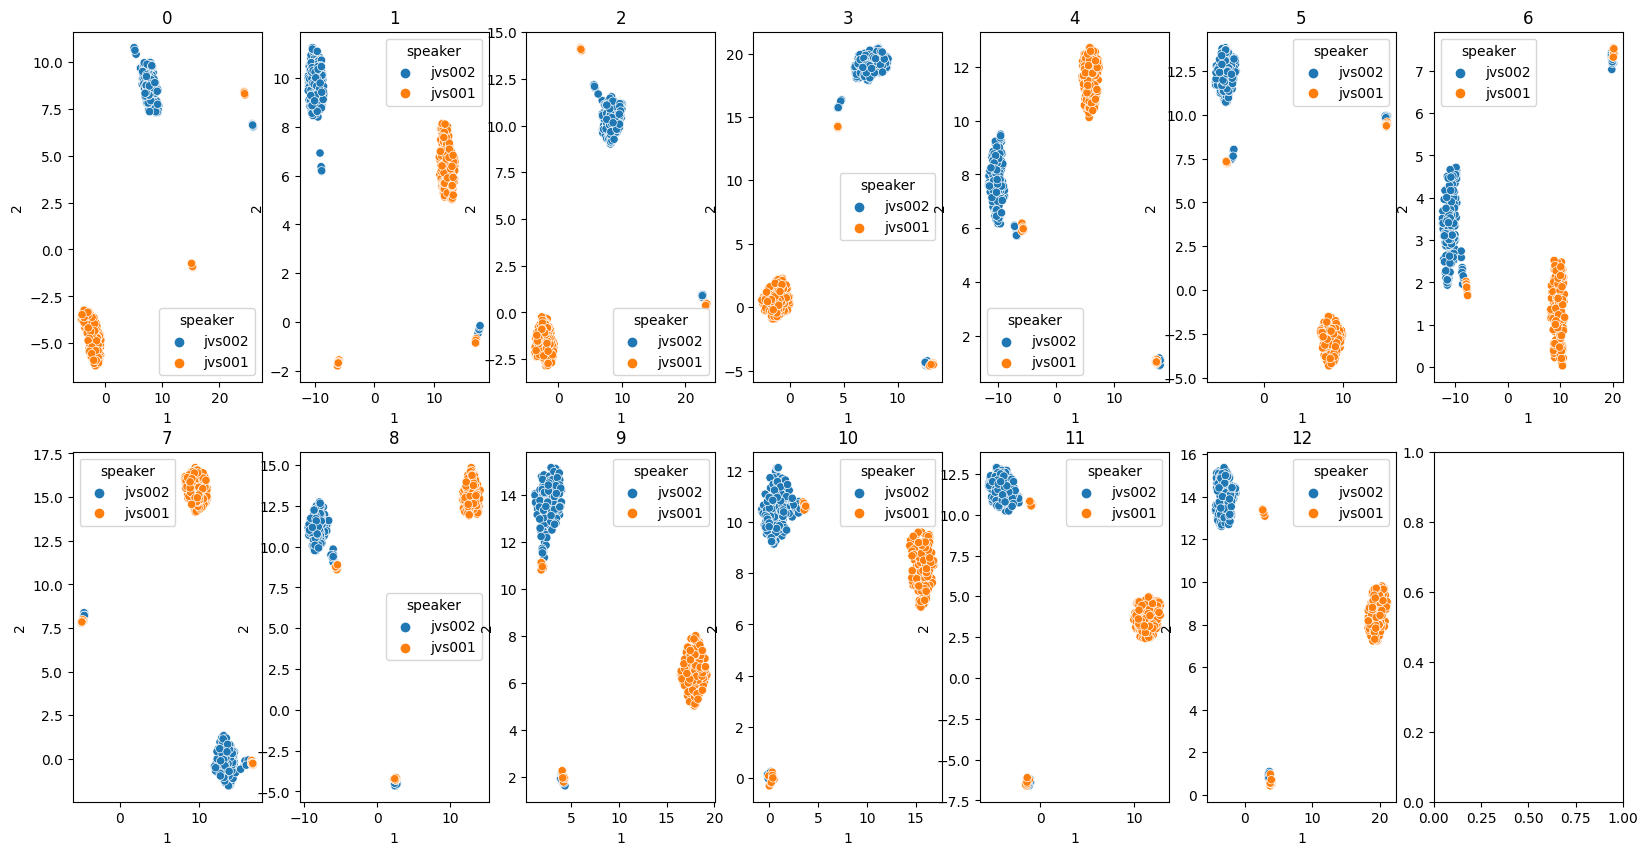

In [21]:
import umap
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
fig,ax = plt.subplots(2,7,figsize=(20,10))
for i in range(outputs[0].shape[0]):
    df = pd.DataFrame()
    df['speaker'] = speakers
    df['embedding'] = [o[i].squeeze(0) for o in outputs]
    plot_df = df[df['speaker'].str.contains('jvs001|jvs002',regex=True)]
    u = umap.UMAP().fit_transform( np.stack(plot_df['embedding'].to_list()))
    plot_df['1'] = u[:,0]
    plot_df['2'] = u[:,1]
    sns.scatterplot(data=plot_df,x='1',y='2',hue='speaker',ax=ax[i//7,i%7])
    ax[i//7,i%7].set_title(f"{i}")
plt.show()

/tmp/ipykernel_1027939/2420583470.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df['1'] = u[:,0]
/tmp/ipykernel_1027939/2420583470.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df['2'] = u[:,1]
/tmp/ipykernel_1027939/2420583470.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html

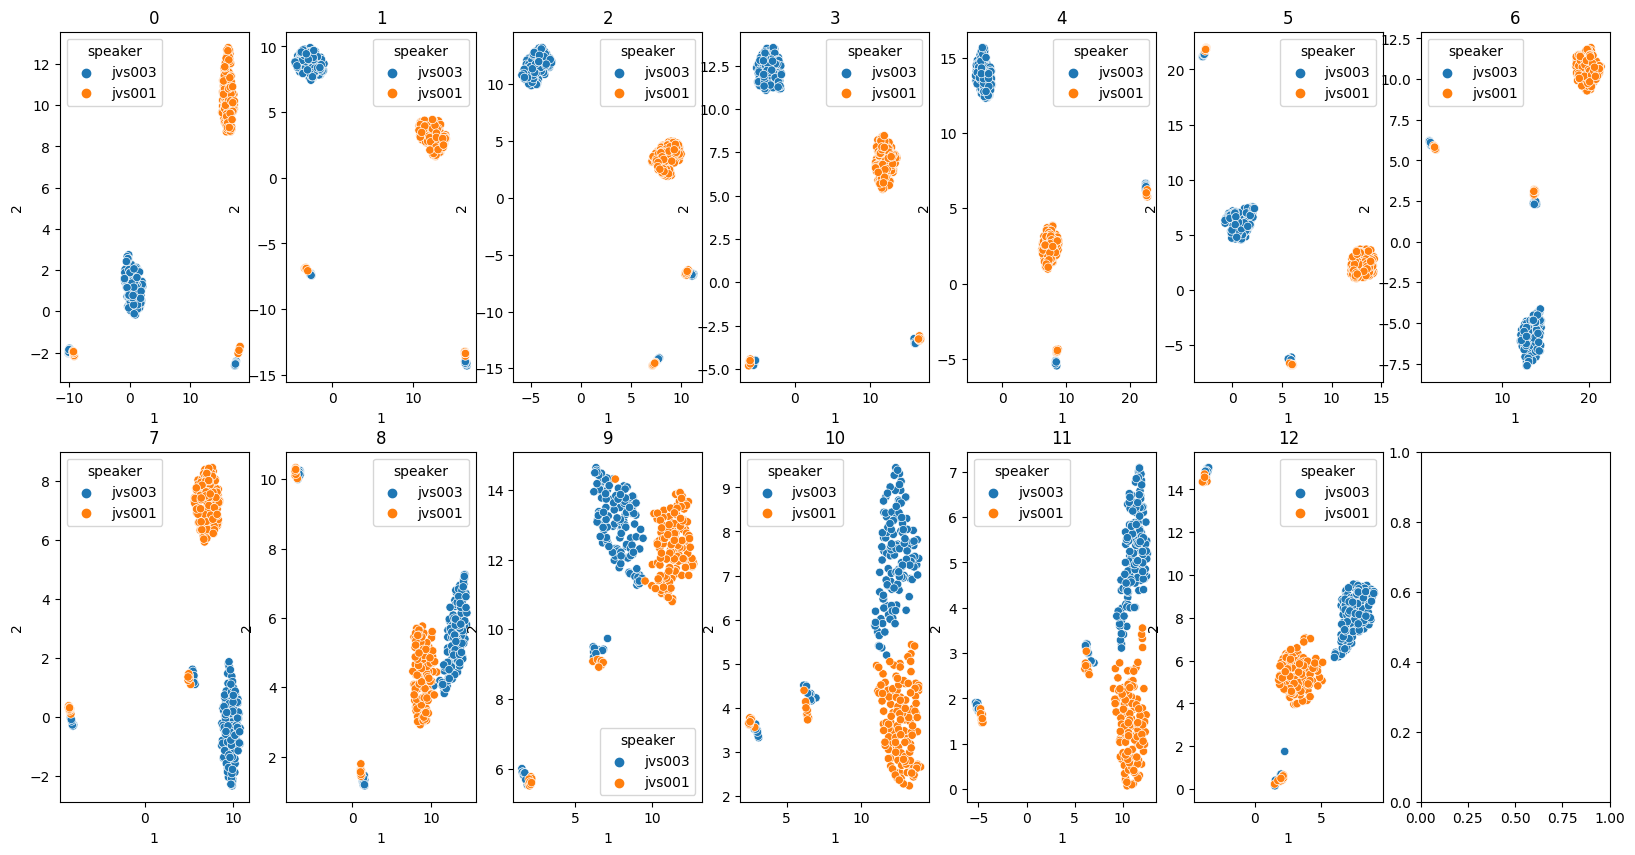

In [25]:
fig,ax = plt.subplots(2,7,figsize=(20,10))
for i in range(outputs[0].shape[0]):
    df = pd.DataFrame()
    df['speaker'] = speakers
    df['embedding'] = [o[i].squeeze(0) for o in outputs]
    plot_df = df[df['speaker'].str.contains('jvs001|jvs003',regex=True)]
    u = umap.UMAP().fit_transform( np.stack(plot_df['embedding'].to_list()))
    plot_df['1'] = u[:,0]
    plot_df['2'] = u[:,1]
    sns.scatterplot(data=plot_df,x='1',y='2',hue='speaker',ax=ax[i//7,i%7])
    ax[i//7,i%7].set_title(f"{i}")
plt.show()

In [20]:
np.stack(plot_df['embedding'].to_list()).shape

(300, 768)

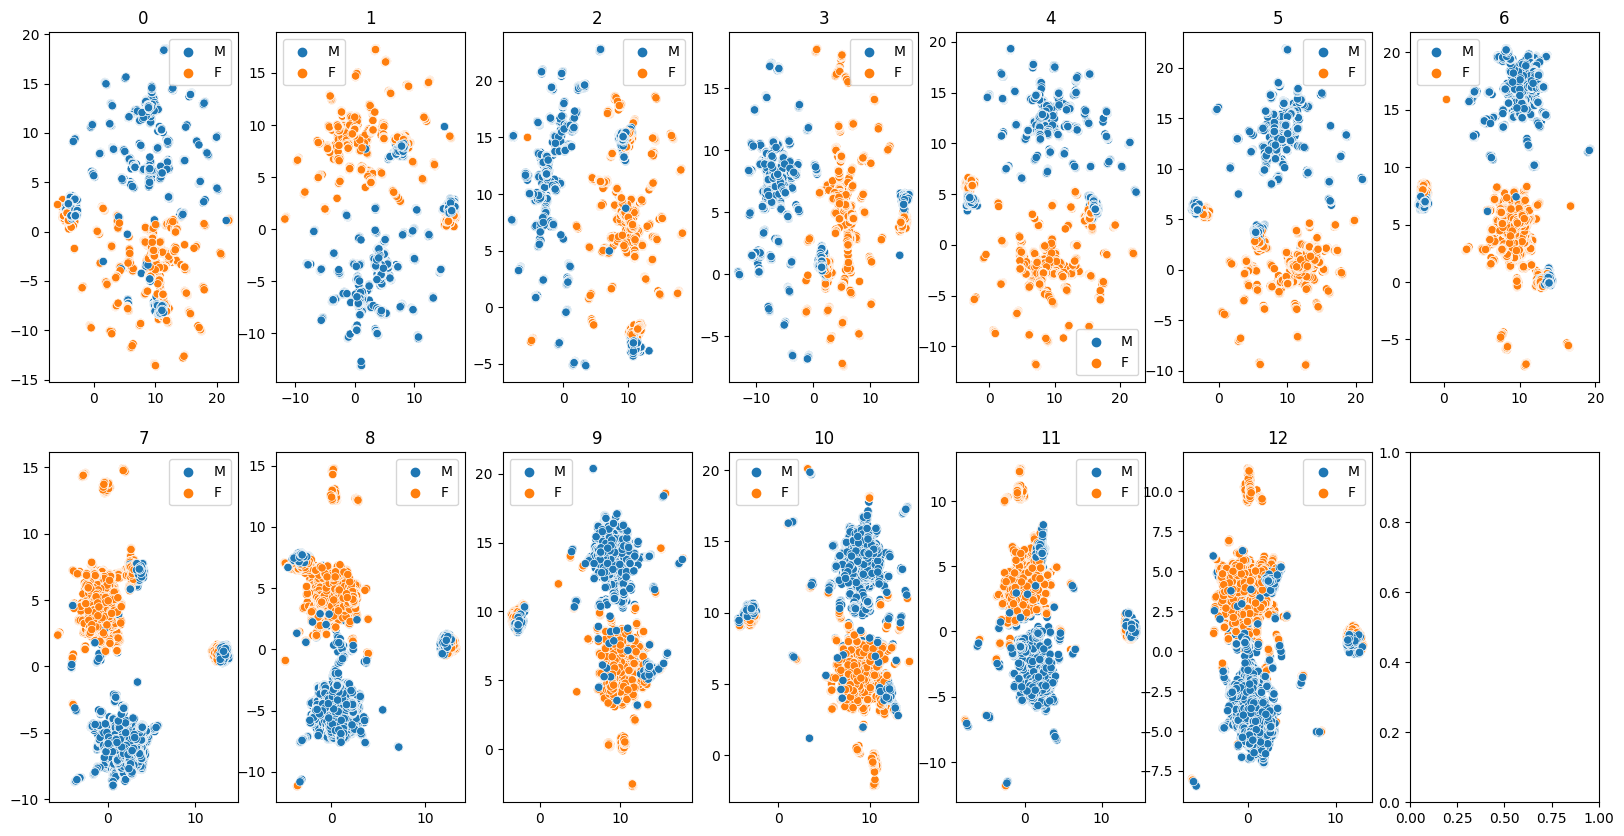

In [41]:
import umap
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
fig,ax = plt.subplots(2,7,figsize=(20,10))
for i in range(outputs[0].shape[0]):
    u = umap.UMAP().fit_transform( np.stack(outputs)[:,i,:,:].squeeze(1))
    sns.scatterplot(x=u[:,0],y=u[:,1],hue=np.stack([gender[s] for s in speakers]),ax=ax[i//7,i%7])
    ax[i//7,i%7].set_title(f"{i}")
plt.show()

In [49]:
import torchaudio
import torch
from pathlib import Path
from tqdm import tqdm
import random
wav_files = list(Path("/mnt/hdd/datasets/jvs_ver1/").glob("**/VOICEACTRESS100_*.wav"))
wav_files = random.sample(wav_files,1000)
phoneme_outputs = []
filenames = []
wavlm_model.to('cuda')
outputs = []
speakers = []
for wav_file in tqdm(wav_files):
    alignment_file = Path(f"/mnt/hdd/datasets/jvs_ver1/jvs_r9y9-dev/aligned_labels_openjtalk/{wav_file.parents[2].name}/{wav_file.stem}.lab")
    if not alignment_file.exists():
        continue
    with alignment_file.open() as f:
        lines = f.readlines()
    wav_tensor,sr = torchaudio.load(wav_file)
    wav_tensor = torchaudio.functional.resample(waveform=wav_tensor,orig_freq=sr,new_freq=16_000)
    inputs = processor(wav_tensor.squeeze(),return_tensors='pt',sampling_rate=16_000)
    inputs.to('cuda')
    with torch.no_grad():
        output = wavlm_model(**inputs,output_hidden_states=True)
    speaker = wav_file.parents[2].name
    for l in lines:
        s,e,p = l.strip().split()
        start_index = int(float(s)*16_000/320.0)
        end_index = int(float(e)*16_000/320.0)

        outputs.append(torch.stack(output.hidden_states)[:,:,start_index:end_index,:].mean(axis=2).squeeze().cpu().numpy())
        phoneme_outputs.append(p)
        speakers.append(speaker)
        filenames.append(wav_file)

  0%|          | 0/1000 [00:00<?, ?it/s]/home/wnakata/lightning-vocoders/.venv/lib/python3.10/site-packages/torch/nn/functional.py:4999: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
100%|██████████| 1000/1000 [01:28<00:00, 11.25it/s]


In [58]:
for output in outputs:
    if output.shape != (13,768):
        print(output.shape)
np.stack(outputs).shape

(76793, 13, 768)

In [66]:
np.isnan(np.stack(outputs)[:,0]).any(axis=1).shape

(76793,)

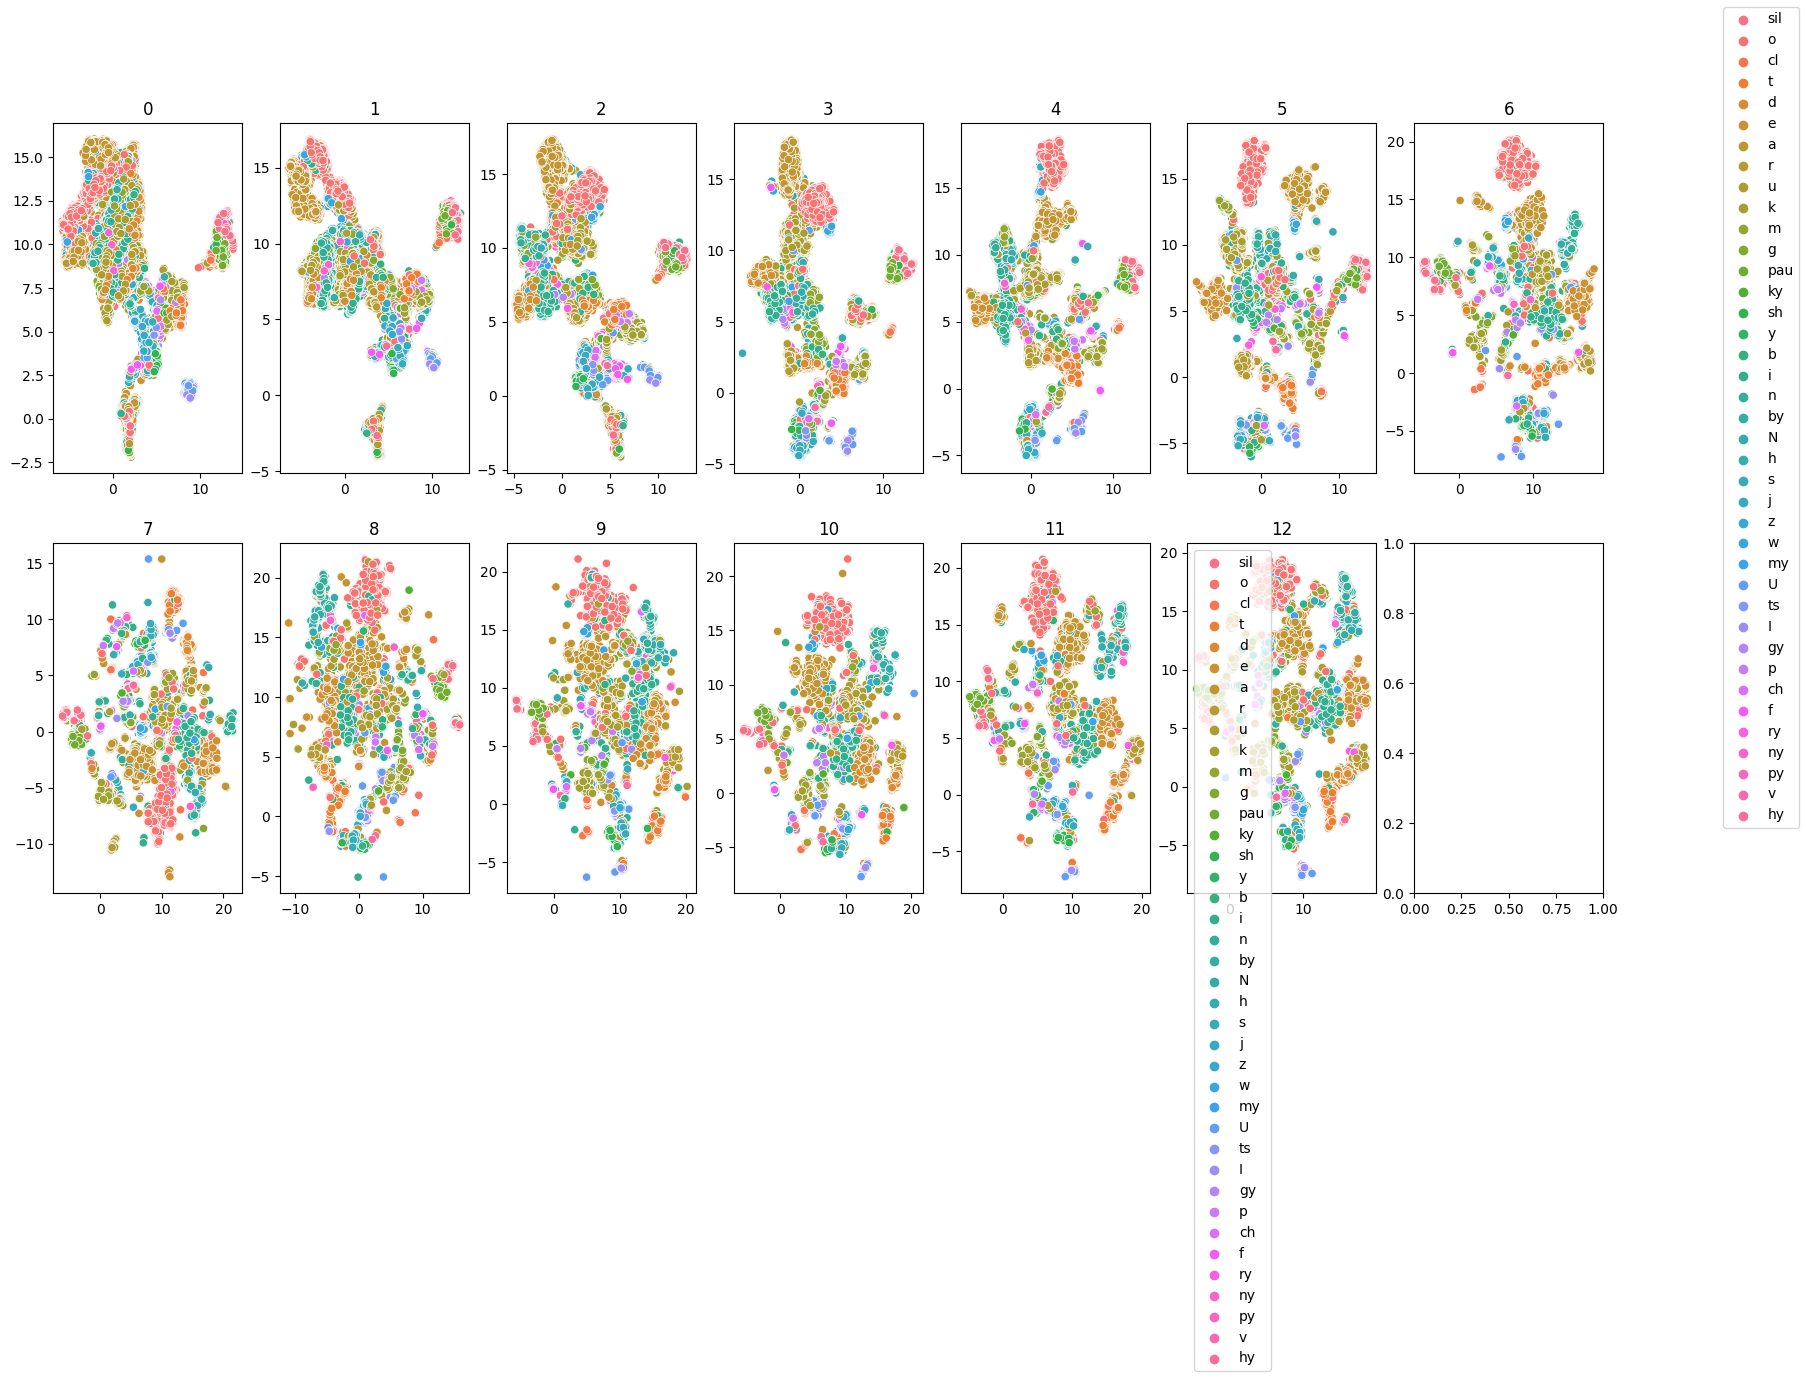

In [77]:
import umap
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
fig,ax = plt.subplots(2,7,figsize=(20,10))
for i in range(outputs[0].shape[0]):
    u = umap.UMAP().fit_transform( np.stack(outputs)[~np.isnan(np.stack(outputs)[:,i]).any(axis=1),i])
    sns.scatterplot(x=u[:,0],y=u[:,1],hue=np.stack(phoneme_outputs)[~np.isnan(np.stack(outputs)[:,i]).any(axis=1)],ax=ax[i//7,i%7])
    ax[i//7,i%7].set_title(f"{i}")
    if i != (outputs[0].shape[0] -1):
        ax[i//7,i%7].get_legend().remove()
handles, labels = ax[i//7,i%7].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')
plt.show()

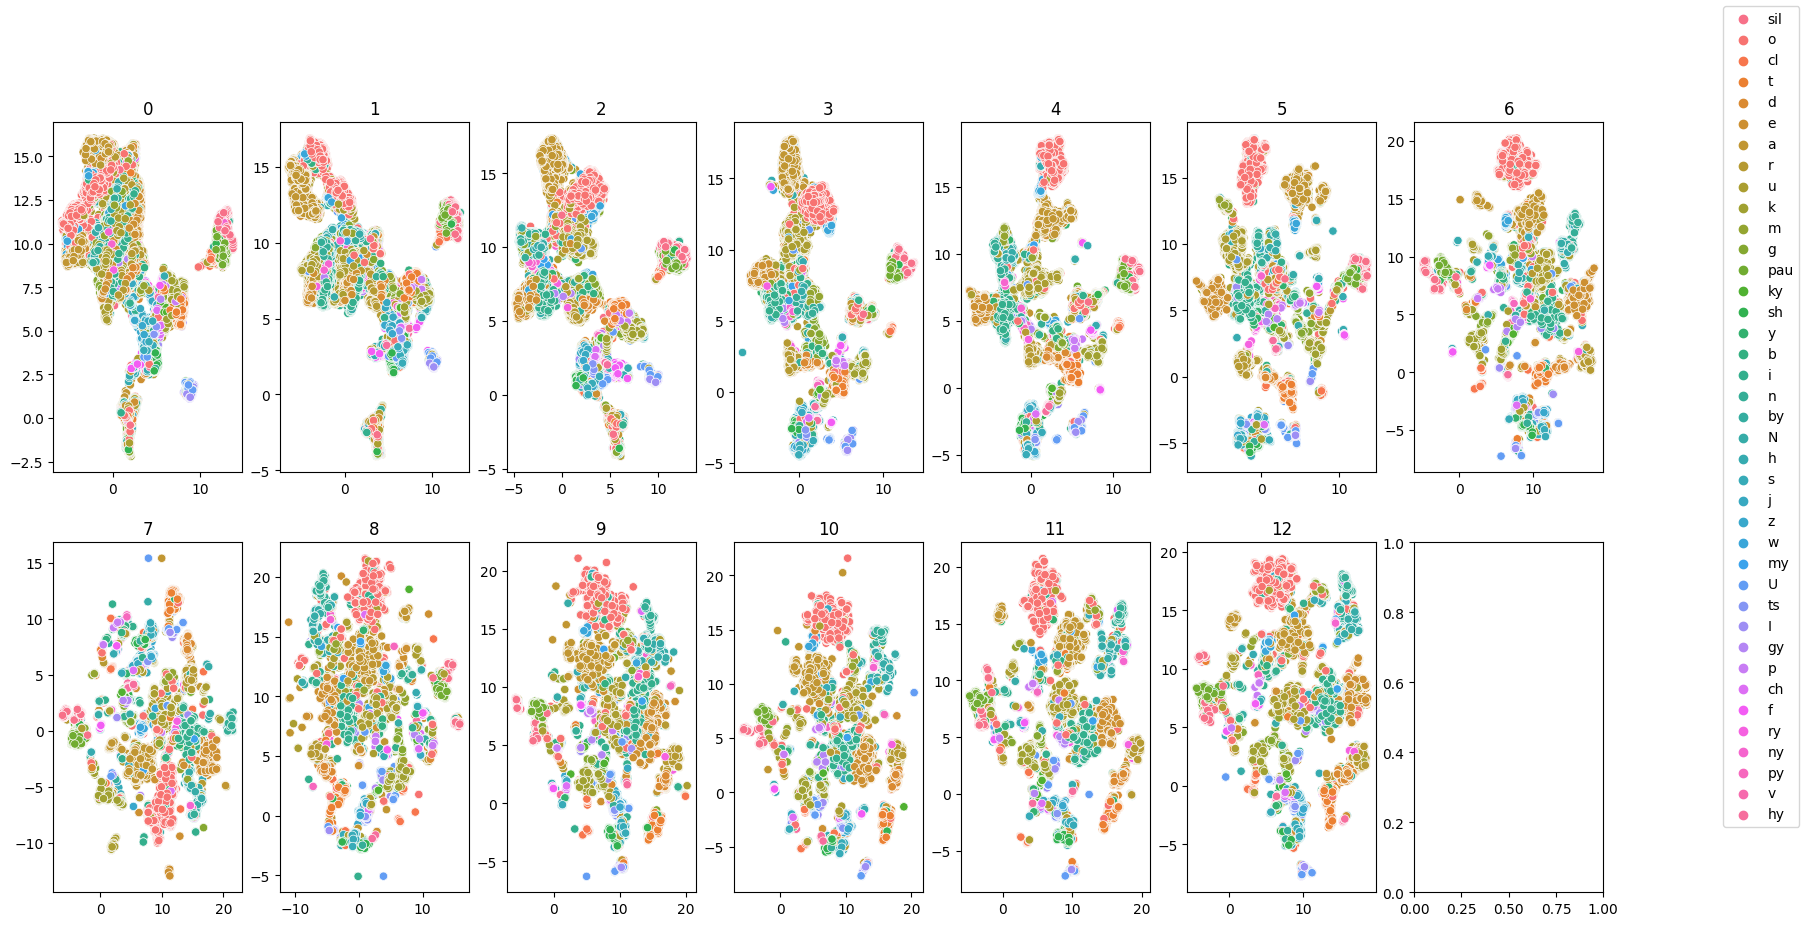

In [78]:
ax[i//7,i%7].get_legend().remove()
fig

In [ ]:
fig.

In [48]:
for output in outputs:
    output.shape

ValueError: all input arrays must have the same shape

In [204]:
np.stack(phoneme_outputs)[~np.isnan(np.stack(outputs)).any(axis=1)]

array(['sil', 'h', 'o', ..., 'r', 'u', 'sil'], dtype='<U3')

In [215]:
from matplotlib import pyplot as plt
import pandas as pd
df = pd.DataFrame()
df['embedding_1'] = mapper.embedding_[:,0]
df['embedding_2'] = mapper.embedding_[:,1]
df['phones'] = np.stack(phoneme_outputs)[~np.isnan(np.stack(outputs)).any(axis=1)]

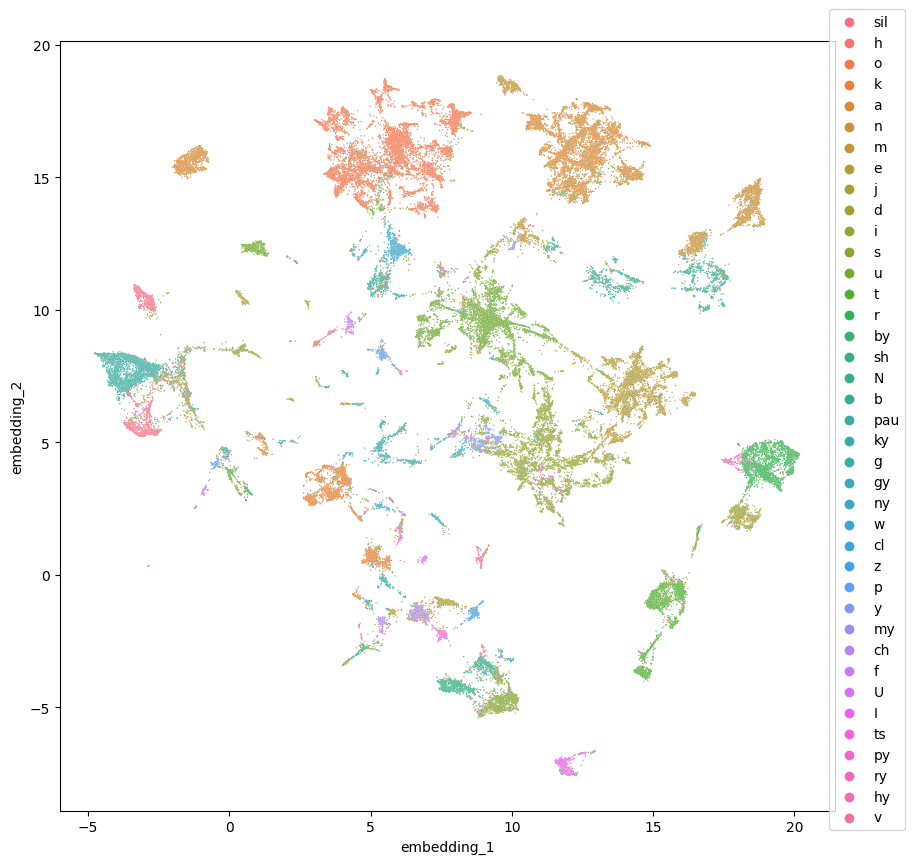

In [222]:
import seaborn as sns
plt.figure(figsize=(10,10))
ax = sns.scatterplot(data=df,x='embedding_1',y='embedding_2',hue='phones',s=1)
ax.legend(bbox_to_anchor=(1.1, 1.05))